<center>
  <font size="8">ISE 244 Project : </font><br>
 <font size="6"> Speech Emotion Recognition using Advanced Machine Learning Models</font><br>
  <font size="6">Aditya Sahu (016237819)</font><br>

This note book will extend the implementation of Reference Paper: [Bagged support vector machines for emotion recognition from speech](https://www.sciencedirect.com/science/article/pii/S0950705119303533?casa_token=FGaqQ4VbD2EAAAAA:2t-2j0xgAcoUsrx_MOGVTP7ICPXu_B3vlSC0pcS3SmaGyYWLYTKJKuAkVBLH7TH3cF_QVTjYeA)


In [1]:
base_path = "C:/Users/adity/Downloads/ISE/"


In [3]:
import librosa
import librosa.display
import soundfile
import os, glob, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.utils import to_categorical
from boruta import BorutaPy
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Bidirectional


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# DataSet

The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) is a comprehensive dataset used widely for research in emotions recognition. It consists of 24 professional actors (12 male, 12 female) vocalizing two lexically-matched statements in a neutral North American accent. Performances are available in three modalities: speech, song, and silent video. Each recording is available as a video and audio-only file.

The actors express eight different emotions: neutral, calm, happy, sad, angry, fearful, surprise, and disgust, along with two levels of emotional intensity (normal and strong). Additionally, there are two levels for the calm emotion. This dataset is frequently used for training and benchmarking models in speech and facial expression recognition tasks, making it valuable for research in psychology, artificial intelligence, and computer vision.

In [4]:
def show_emotion_waveplot(file_path: str):
    visited = list()
    files = []
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 8), sharey=True)
    for f in glob.glob(file_path):
        file_name = os.path.basename(f)
        attrs = file_name.split("-")
        if attrs[2] in visited:
            continue
        visited.append(attrs[2])
        files.append(f)
    for i, ax in enumerate(axes.flat):
        if i < len(files):
            audio_path = files[i]
            y, sr = librosa.load(audio_path)
            librosa.display.waveshow(y, sr=sr, ax=ax)
            ax.set_title(f'{emotions[visited[i]].upper()}')
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Amplitude')
    fig.suptitle(f"{file_path.split('/')[1]}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  
    plt.show()


In [5]:
# Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

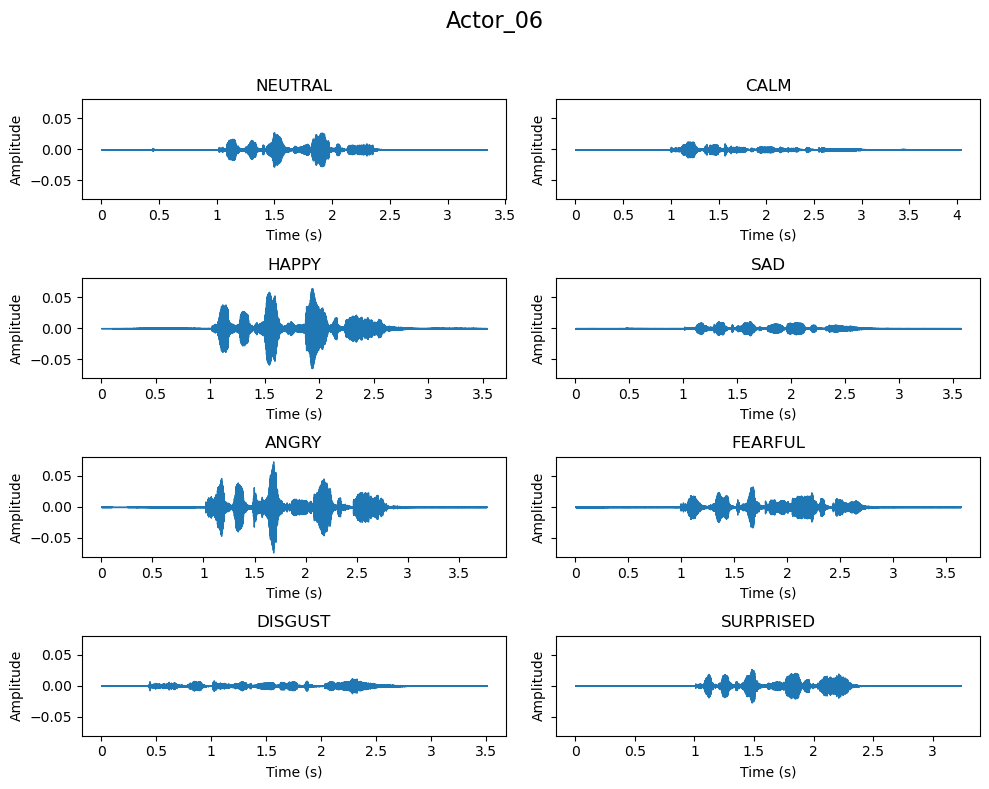

In [5]:
show_emotion_waveplot("./Actor_06/*.wav")

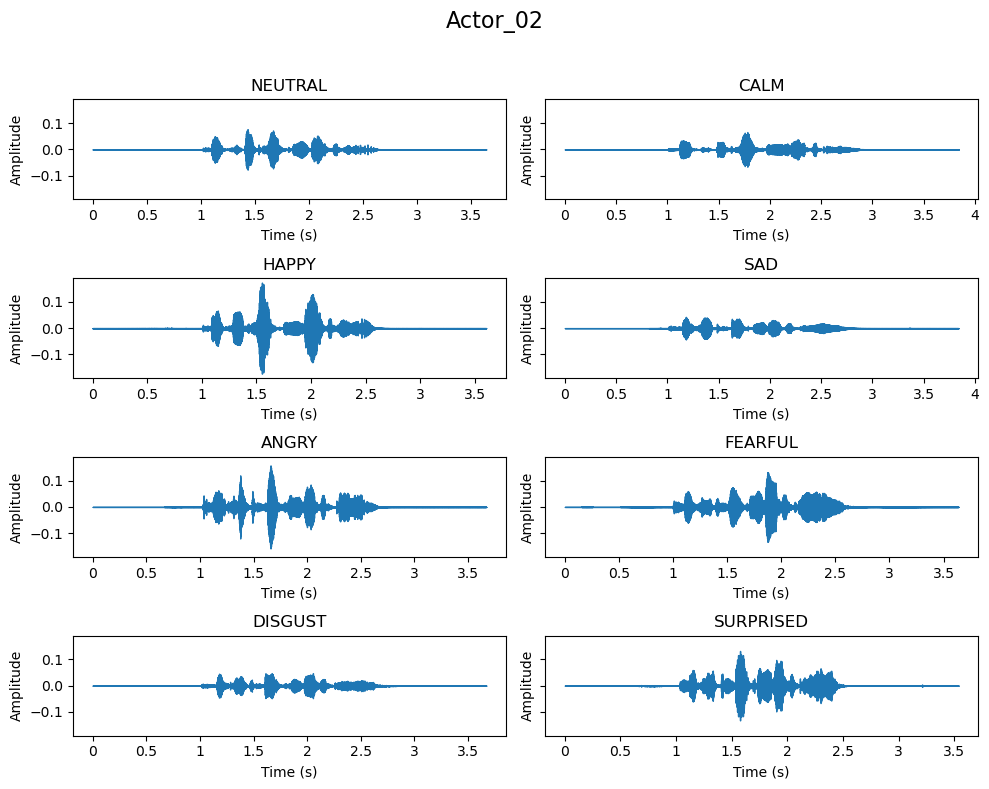

In [6]:
show_emotion_waveplot("./Actor_02/*.wav")

## Data Analysis

In [6]:
# Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc=True, chroma=True, mel=True, rms=True, zero_crossing_rate=True, spectral_centroid=True, spectral_bandwidth=True, spectral_contrast=True, spectral_rolloff=True):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        # print(sample_rate)
        stft = np.abs(librosa.stft(X))
        counter=0
        result = np.array([])

        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13).T, axis=0)
            result = np.hstack((result, mfccs))

        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma))

        if mel:
            mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel))

        if rms:
            rms_value = np.mean(librosa.feature.rms(y=X).T, axis=0)
            result = np.hstack((result, rms_value))

        if zero_crossing_rate:
            zero_crossing_rate_value = np.mean(librosa.feature.zero_crossing_rate(y=X).T, axis=0)
            result = np.hstack((result, zero_crossing_rate_value))

        if spectral_centroid:
            centroid = np.mean(librosa.feature.spectral_centroid(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, centroid))

        if spectral_bandwidth:
            bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, bandwidth))

        if spectral_contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, contrast))

        if spectral_rolloff:
            rolloff = np.mean(librosa.feature.spectral_rolloff(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, rolloff))

    return result

In [7]:
# Load the data and extract features for each sound file
file_names, vocal_channels, emo, emo_intensity, repetitions, actor_gender  = [], [], [], [], [], []
def load_data(test_size):
    x,y=[],[]
    for file in glob.glob("./Actor_*/*.wav"):
        file_name=os.path.basename(file)
        attributes = file_name.split("-")
        file_names.append(file_name)
        vocal_channels.append(attributes[1])
        emotion=emotions[attributes[2]]
        emo.append(emotion)
        emo_intensity.append(attributes[3])
        repetitions.append(attributes[5])
        actor_gender.append("Female" if int(attributes[6].split(".")[0])%2==0 else "Male")
        feature=extract_feature(file)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=42)

## We will Split our dataset in 90:10 , since our reference paper has taken the same ratio

In [8]:
# Split the dataset
x_train, x_test, y_train, y_test = load_data(test_size=0.1)

In [10]:
# Get the shape of the training and testing datasets
print(f"Total Files: {x_train.shape[0] + x_test.shape[0]}, Train: {x_train.shape[0]}, Test: {x_test.shape[0]}")

Total Files: 1441, Train: 1296, Test: 145


In [11]:
x_train.shape

(1296, 165)

In [12]:
x_train[1].shape

(165,)

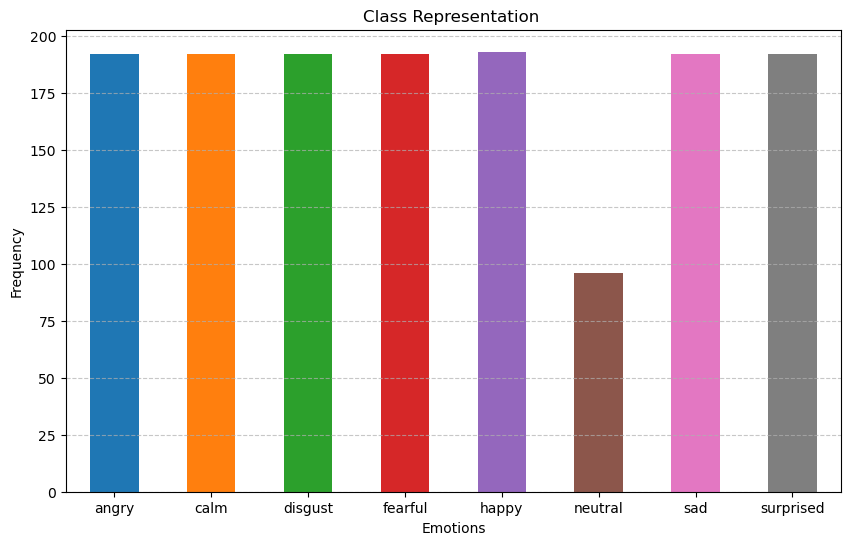

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

y_combined = np.concatenate([y_train, y_test])

# Convert the combined array to pandas Series
y_combined_series = pd.Series(y_combined)

class_counts = y_combined_series.value_counts()

class_counts = class_counts.sort_index()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

# Plotting the class distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar',color=colors)
plt.title('Class Representation ')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


The emotions are mostly balanced, except for the 'neutral' category, which has half the representation compared to other emotions. This disparity might present a challenge in training the models, as there is a risk of underfitting to less represented classes. 

In [14]:
y_combined_series.value_counts()

happy        193
angry        192
disgust      192
fearful      192
surprised    192
sad          192
calm         192
neutral       96
dtype: int64

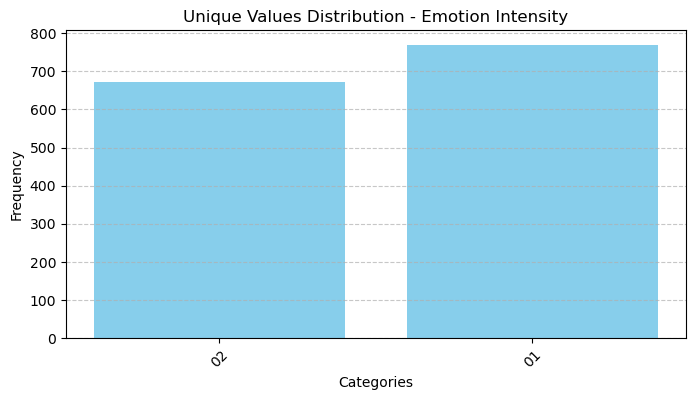

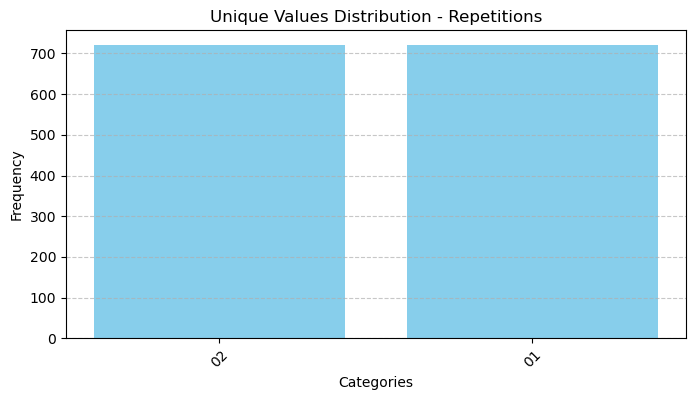

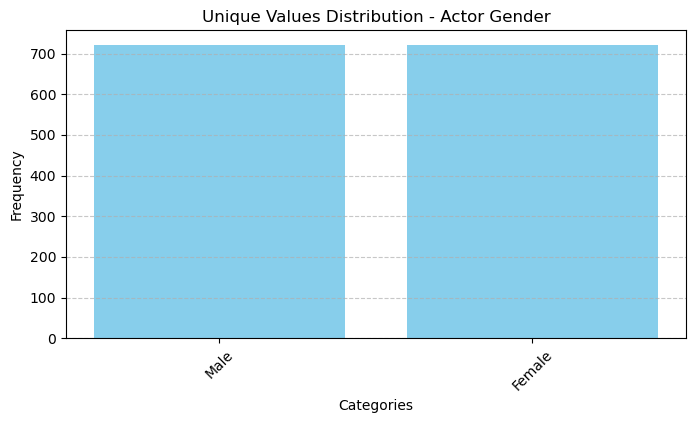

In [15]:
data_col = [
    (emo_intensity, 'Emotion Intensity'),
    (repetitions, 'Repetitions'),
    (actor_gender, 'Actor Gender')
]

# Function to plot unique values for a given list
def plot_unique_values(data_list, title):
    # Convert list to set to find unique values, then back to list to count occurrences
    unique_values = list(set(data_list))
    counts = [data_list.count(value) for value in unique_values]
    
    # Plotting
    plt.figure(figsize=(8, 4))
    plt.bar(unique_values, counts, color='skyblue')
    plt.title(f'Unique Values Distribution - {title}')
    plt.xlabel('Categories')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plotting unique values for each list
for list_data, label in data_col:
    plot_unique_values(list_data, label)

The dataset is perfectly balanced with respect to gender, with equal counts of male and female actors (12 each). This balance is crucial for training models that are gender-neutral and capable of accurately identifying emotions regardless of the speaker's gender.

## Implementing [Bagged support vector machines for emotion recognition from speech](https://www.sciencedirect.com/science/article/pii/S0950705119303533?casa_token=FGaqQ4VbD2EAAAAA:2t-2j0xgAcoUsrx_MOGVTP7ICPXu_B3vlSC0pcS3SmaGyYWLYTKJKuAkVBLH7TH3cF_QVTjYeA)


Reference Paper: Bagged support vector machines for emotion recognition from speech

## Reference Paper Model: Ensemble SVM Model

### Feature Engineering

In [16]:
from scipy.stats import skew, kurtosis, iqr

# Overwriting the previous feature extraction function to meet requirements of the paper
def extract_feature(file_name):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        stft = np.abs(librosa.stft(X, n_fft=512))
        counter=0
        result = np.array([])

        mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
        delta = librosa.feature.delta(mfccs)
        delta_delta = librosa.feature.delta(mfccs, order=2)
        # Compute the mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=26)

        # Calculate the spectral centroids
        centroids = librosa.feature.spectral_centroid(S=mel_spectrogram)

        # Calculate additional statistics for MFCCs
        mean_mfccs = np.mean(mfccs.T, axis=0)
        var_mfccs = np.var(mfccs.T, axis=0)
        max_mfccs = np.max(mfccs.T, axis=0)
        min_mfccs = np.min(mfccs.T, axis=0)
        skew_mfccs = skew(mfccs.T, axis=0)
        kurtosis_mfccs = kurtosis(mfccs.T, axis=0)
        iqr_mfccs = iqr(mfccs.T, axis=0)

        result_mfcc = np.hstack((mean_mfccs, var_mfccs, max_mfccs, min_mfccs, skew_mfccs, kurtosis_mfccs, iqr_mfccs))

        # Calculate additional statistics for Delta
        mean_delta = np.mean(delta.T, axis=0)
        var_delta = np.var(delta.T, axis=0)
        max_delta = np.max(delta.T, axis=0)
        min_delta = np.min(delta.T, axis=0)
        skew_delta = skew(delta.T, axis=0)
        kurtosis_delta = kurtosis(delta.T, axis=0)
        iqr_delta = iqr(delta.T, axis=0)

        result_delta = np.hstack((mean_delta, var_delta, max_delta, min_delta, skew_delta, kurtosis_delta, iqr_delta))

        # Calculate additional statistics for Delta Delta
        mean_delta_delta = np.mean(delta_delta.T, axis=0)
        var_delta_delta = np.var(delta_delta.T, axis=0)
        max_delta_delta = np.max(delta_delta.T, axis=0)
        min_delta_delta = np.min(delta_delta.T, axis=0)
        skew_delta_delta = skew(delta_delta.T, axis=0)
        kurtosis_delta_delta = kurtosis(delta_delta.T, axis=0)
        iqr_delta_delta = iqr(delta_delta.T, axis=0)

        result_delta_delta = np.hstack((mean_delta_delta, var_delta_delta, max_delta_delta, min_delta_delta, skew_delta_delta, kurtosis_delta_delta, iqr_delta_delta))

        # Calculate additional statistics for Spectral Centroids
        centroids_mean = np.mean(mel_spectrogram, axis=1)
        centroids_var = np.var(mel_spectrogram, axis=1)
        centroids_max = np.max(mel_spectrogram, axis=1)
        centroids_min = np.min(mel_spectrogram, axis=1)
        centroids_skew = skew(mel_spectrogram, axis=1)
        centroids_kurtosis = kurtosis(mel_spectrogram, axis=1)
        centroids_iqr = iqr(mel_spectrogram, axis=1)

        result_spectral_centroids = np.hstack((centroids_mean,centroids_var,centroids_max,centroids_min,centroids_skew,centroids_kurtosis,centroids_iqr))

        # Concatenate all aggregated features
        result = np.hstack((result,result_mfcc, result_delta, result_delta_delta, result_spectral_centroids))

    return result


### Note: Original Paper takes a 90:10 split in Training and Test data, Thus we will follow the same

In [17]:
x_train_svc, x_test_svc, y_train_svc, y_test_svc = load_data(test_size=0.1)

In [18]:
# Min-Max Scaling
from sklearn.preprocessing import MinMaxScaler
import numpy as np
scaler = MinMaxScaler()

# Fit and transform the features
x_train_svc = scaler.fit_transform(x_train_svc)
x_test_svc = scaler.transform(x_test_svc)

In [19]:
print(x_train_svc.shape)

(1296, 455)


### Data Balancing using SMOTE-TOMEK Links

SMOTE-TOMEK Links combines the Synthetic Minority Over-sampling Technique (SMOTE) and Tomek Links to balance the dataset effectively. This approach not only augments the minority class through synthetic samples but also cleans overlapping samples between classes, which can enhance the decision boundary for the SVM model. This method involves creating synthetic samples from the minority class to prevent overfitting issues that arise due to an imbalanced dataset. By interpolating new points between existing minority class samples, SMOTE helps in providing more examples for the model to learn from, thus improving its generalization capabilities.

In [20]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

smote_tomek = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
x_train_svc, y_train_svc = smote_tomek.fit_resample(x_train_svc, y_train_svc)

In [21]:
print(x_train_svc.shape)

(1462, 455)


In [22]:
import pandas as pd

y_train_series = pd.Series(y_train_svc)

# Get the distribution of classes
class_distribution = y_train_series.value_counts()

# Print the distribution
print("Class Distribution in y_train:")
print(class_distribution)

Class Distribution in y_train:
happy        183
disgust      183
neutral      183
fearful      183
surprised    183
sad          183
calm         183
angry        181
dtype: int64


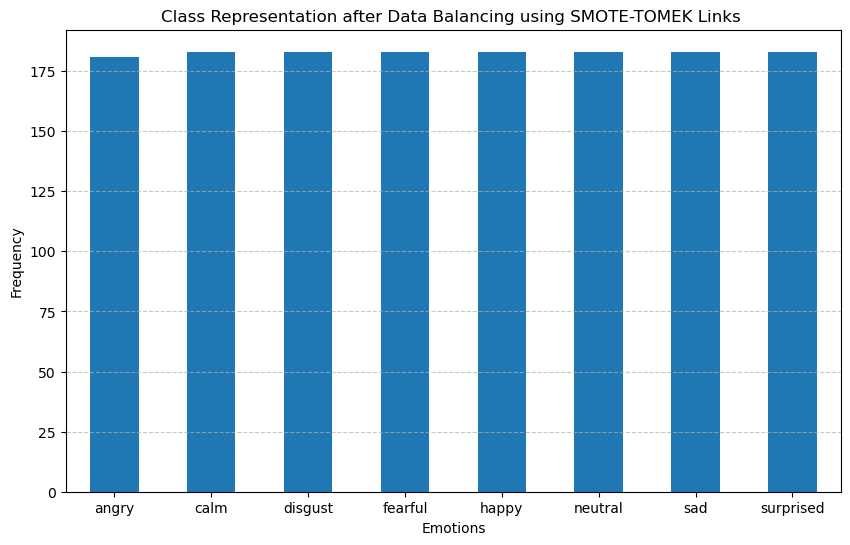

In [23]:
class_counts = class_distribution.sort_index()

# Plotting the class distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Class Representation after Data Balancing using SMOTE-TOMEK Links ')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.xticks(rotation=0) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

This balanced dataset aids in addressing the previously identified issue of under-representation of the 'neutral' emotion, ensuring that each emotion category is equally represented, thus providing a fair basis for training the Ensemble SVM model.

After using SMOTE-TOMEK links we get balanced number of Emotions, each around 166.


### Feature Selection Using Boruta


Boruta is an all-relevant feature selection method that robustly identifies the most important features that contribute to the predictive model. By using a random forest classifier as a base, Boruta iteratively compares the importance of real features with that of random shadows and retains only those features which prove to be more significant than the best random shadows. The Boruta algorithm repeatedly assesses the importance of each feature against a randomized benchmark, ensuring that only features with statistically significant contributions to the model's predictive power are selected. This not only helps in enhancing model performance but also reduces computational complexity and improves interpretability by eliminating redundant or irrelevant features.


The balanced dataset and refined feature set are used to train an Ensemble SVM model, following the approach used in the reference study. The Ensemble SVM, which employs a bagging technique with multiple SVM classifiers, benefits significantly from the balanced and selectively refined dataset. The use of multiple diverse classifiers in an ensemble reduces variance and avoids overfitting, while the balanced and feature-optimized dataset ensures that the ensemble has a strong and diverse set of examples from each class to learn from. 


In [24]:
forest = RandomForestClassifier(n_jobs = -1)
boruta = BorutaPy(estimator = forest, n_estimators = 'auto', max_iter = 100)

### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(x_train_svc, y_train_svc)

BorutaPy(estimator=RandomForestClassifier(n_estimators=276, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x27387826940),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x27387826940)

In [25]:
x_train_svc[:,np.logical_or(boruta.support_, boruta.support_weak_)].shape
x_train_selected = x_train_svc[:,boruta.support_]
X_test_selected = x_test_svc[:,boruta.support_]

### Model Training - Bagging SVC

In [26]:
model = BaggingClassifier(base_estimator=SVC(), n_estimators=20)
model.fit(x_train_selected, y_train_svc)


BaggingClassifier(base_estimator=SVC(), n_estimators=20)

In [27]:
# Predict for the test set
y_pred = model.predict(X_test_selected)
y_train_pred = model.predict(x_train_selected)


Train Classification Report:
              precision    recall  f1-score   support

       angry       0.94      0.80      0.86       181
        calm       0.68      0.89      0.77       183
     disgust       0.73      0.87      0.80       183
     fearful       0.76      0.80      0.78       183
       happy       0.84      0.64      0.73       183
     neutral       0.73      0.91      0.81       183
         sad       0.74      0.43      0.54       183
   surprised       0.78      0.79      0.78       183

    accuracy                           0.77      1462
   macro avg       0.77      0.77      0.76      1462
weighted avg       0.77      0.77      0.76      1462



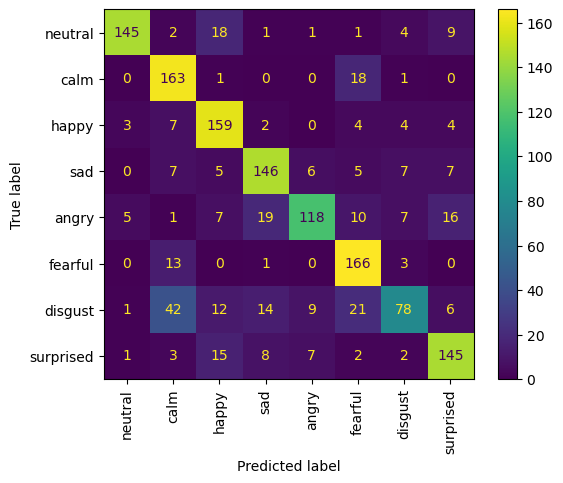

In [28]:
print("\nTrain Classification Report:")
print(classification_report(y_train_svc, y_train_pred))
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_train_svc, y_train_pred, display_labels=list(emotions.values()), xticks_rotation = 'vertical')

## Result: Ensemble SVM Model Accuracy is 77% for Traning Dataset


Test Classification Report:
              precision    recall  f1-score   support

       angry       0.88      0.70      0.78        20
        calm       0.59      0.76      0.67        21
     disgust       0.68      0.79      0.73        24
     fearful       0.64      0.75      0.69        12
       happy       0.74      0.64      0.68        22
     neutral       0.75      0.82      0.78        11
         sad       0.00      0.00      0.00         9
   surprised       0.73      0.73      0.73        26

    accuracy                           0.69       145
   macro avg       0.63      0.65      0.63       145
weighted avg       0.67      0.69      0.68       145



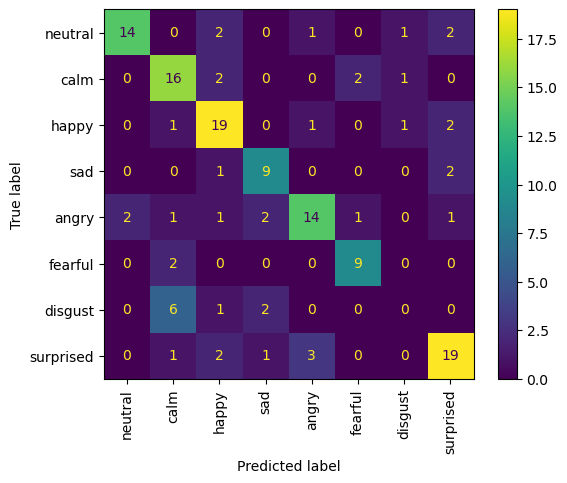

In [29]:
print("\nTest Classification Report:")
print(classification_report(y_test_svc, y_pred))
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test_svc, y_pred, display_labels=list(emotions.values()), xticks_rotation = 'vertical')

## Result: Ensemble SVM Model Accuracy is 69% for Test Dataset

#### Observation: We acheive similar results, which have been acheived in Reference Paper

# Proposed Deep Learning Models

### 1. LSTM
### 2. CNN-LSTM
### 3. CNN-biLSTM

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

from joblib import delayed, Parallel

Since we are going with models which are sequence based, so we would have to change our data into Time-series data

For the proposed sequence-based models, namely LSTM, CNN-LSTM, and CNN-biLSTM, it is necessary to adapt the feature extraction process to suit time-series analysis. This involves transforming raw audio data into structured time-series data that these models can effectively process to recognize emotional states. 

## Creating Time-Series Data

In [31]:
def get_emotion_label_from_filename(filename):
    return filename.split("-")[2]

In [32]:
def process_audio_files(dataset_path):
    data = []
    labels = []
    max_len = 0

    # Iterate through all files in the specified directory
    for filename in glob.glob(dataset_path):
        emotion = get_emotion_label_from_filename(filename)  # Implement this function

        with soundfile.SoundFile(filename) as sound_file:
            X = sound_file.read(dtype="float32")
            sample_rate = sound_file.samplerate
            stft = np.abs(librosa.stft(X))

            # Compute the Mel-frequency cepstral coefficients (MFCCs) from the audio signal
            mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)

            # Compute the chroma feature
            chroma = librosa.feature.chroma_stft(S=np.abs(librosa.stft(X)), sr=sample_rate)

            # Compute the mel spectrogram
            mel = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128)

            rms_value = librosa.feature.rms(y=X)

            zero_crossing_rate_value = librosa.feature.zero_crossing_rate(y=X)

            centroid = librosa.feature.spectral_centroid(y=X, sr=sample_rate)

            bandwidth = librosa.feature.spectral_bandwidth(y=X, sr=sample_rate)

            contrast = librosa.feature.spectral_contrast(S=stft, sr=sample_rate)

            rolloff = librosa.feature.spectral_rolloff(y=X, sr=sample_rate)

            # Concatenate the features along the feature axis
            features = np.concatenate([mfccs, chroma, mel, rms_value,
                                       zero_crossing_rate_value, centroid,
                                       bandwidth, contrast, rolloff], axis=0)

            # Update the maximum sequence length
            max_len = max(max_len, features.shape[1])

            # Transpose the MFCC matrix to have time frames as the first dimension
            features = features.T

            data.append(features)
            labels.append(emotion)

    return np.array(data, dtype=object), np.array(labels), max_len

In [33]:
X, Y, max_pad_len = process_audio_files("./Actor_*/*.wav")

Pad all the audio sequences with 0s at end so that each sequence is of same length

In [34]:
X_padded = np.array([np.pad(seq, pad_width=((0, max_pad_len-seq.shape[0]), (0, 0)), mode='constant') for seq in X])
# ((0, max_pad_len-seq.shape[0]), (0, 0)) means 0 rows in begining, 0 at end and then 2nd tuple also same 0 cols in beg and end

In [35]:
X_padded.shape

(1441, 165, 192)

In [36]:
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = to_categorical(label_encoder.fit_transform(Y))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, encoded_labels, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Print the shape of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("max_pad_len:", max_pad_len)

X_train shape: (1152, 165, 192)
X_test shape: (289, 165, 192)
y_train shape: (1152, 8)
y_test shape: (289, 8)
max_pad_len: 165


## Model 1: LSTM

An LSTM (Long Short-Term Memory) model is a type of recurrent neural network (RNN) architecture that is specifically designed to address the vanishing gradient problem and capture long-range dependencies in sequential data. LSTM models are widely used in tasks involving time series prediction, natural language processing (NLP), speech recognition, and more.

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [38]:
early = EarlyStopping(monitor="val_accuracy",mode="max",patience=5, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=1,factor=0.3, min_lr=0.0001, mode = 'max')

callbacks_list = [early, learning_rate_reduction]
callbacks = callbacks_list

model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
model.add(LSTM(100, input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
model.add(LSTM(100, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 165, 100)          117200    
                                                                 
 lstm_1 (LSTM)               (None, 165, 100)          80400     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 150)               15150     
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                                                 
 dense_1 (Dense)             (None, 150)               2

In [39]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, callbacks=callbacks)

Epoch 1/30
33/33 [==============================] - 12s 268ms/step - loss: 2.0775 - accuracy: 0.1400 - val_loss: 2.0583 - val_accuracy: 0.0862 - lr: 0.0010
Epoch 2/30
33/33 [==============================] - 8s 239ms/step - loss: 2.0745 - accuracy: 0.1332 - val_loss: 2.0555 - val_accuracy: 0.1638 - lr: 0.0010
Epoch 3/30
33/33 [==============================] - 8s 246ms/step - loss: 2.0682 - accuracy: 0.1371 - val_loss: 2.0653 - val_accuracy: 0.1207 - lr: 0.0010
Epoch 4/30
33/33 [==============================] - 8s 244ms/step - loss: 2.0729 - accuracy: 0.1236 - val_loss: 2.0658 - val_accuracy: 0.1207 - lr: 0.0010
Epoch 5/30
33/33 [==============================] - 8s 256ms/step - loss: 2.0684 - accuracy: 0.1187 - val_loss: 2.0544 - val_accuracy: 0.1638 - lr: 0.0010
Epoch 6/30
33/33 [==============================] - 8s 250ms/step - loss: 2.0708 - accuracy: 0.1284 - val_loss: 2.0541 - val_accuracy: 0.1207 - lr: 0.0010
Epoch 7/30
33/33 [==============================] - 8s 257ms/step - l

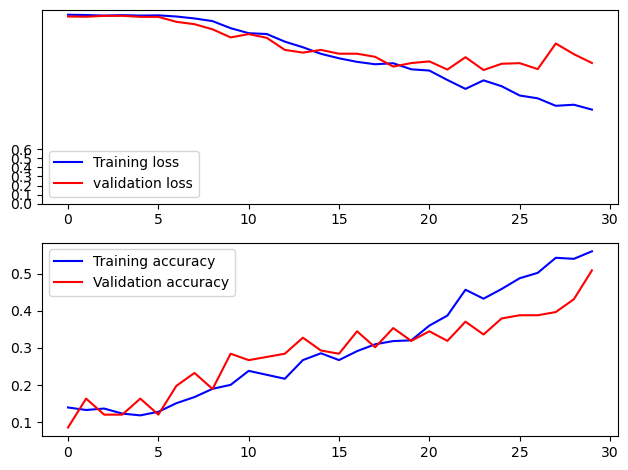

In [40]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

10/10 [==============================] - 2s 80ms/step
              precision    recall  f1-score   support

           0       0.17      0.04      0.07        23
           1       0.37      0.55      0.44        40
           2       0.37      0.60      0.45        42
           3       0.22      0.21      0.22        33
           4       0.82      0.56      0.67        41
           5       0.25      0.27      0.26        26
           6       0.48      0.55      0.51        44
           7       0.65      0.28      0.39        40

    accuracy                           0.42       289
   macro avg       0.41      0.38      0.38       289
weighted avg       0.44      0.42      0.41       289



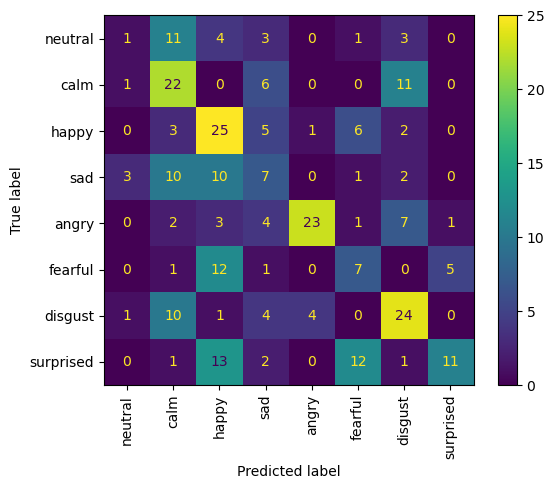

In [41]:
y_pred = model.predict(X_test)
prediction_labels = np.argmax(y_pred, axis = 1)
true_labels = np.argmax(y_test, axis = 1)

print(classification_report(true_labels, prediction_labels))
ConfusionMatrixDisplay.from_predictions(true_labels, prediction_labels, display_labels=list(emotions.values()), xticks_rotation = 'vertical')

## Result: LSTM Model Accuracy is 42% for Traning Dataset

36/36 [==============================] - 3s 85ms/step
              precision    recall  f1-score   support

           0       0.50      0.23      0.32        73
           1       0.64      0.80      0.71       152
           2       0.58      0.80      0.68       151
           3       0.64      0.51      0.57       159
           4       0.84      0.81      0.82       151
           5       0.53      0.45      0.48       166
           6       0.70      0.77      0.73       148
           7       0.64      0.61      0.62       152

    accuracy                           0.65      1152
   macro avg       0.63      0.62      0.62      1152
weighted avg       0.64      0.65      0.64      1152



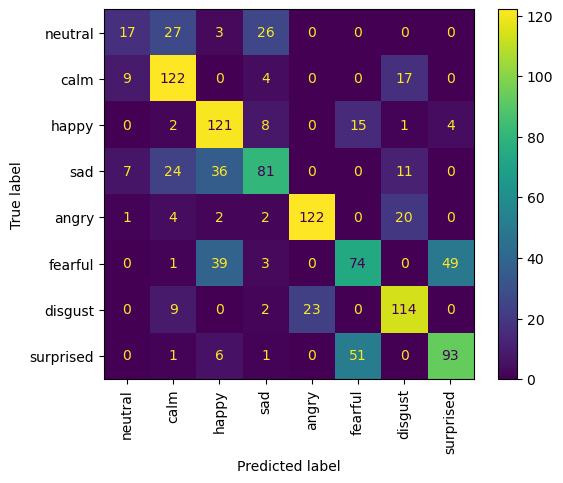

In [42]:
y_pred_train = model.predict(X_train)
prediction_labels_train = np.argmax(y_pred_train, axis = 1)

true_labels_train = np.argmax(y_train, axis = 1)

print(classification_report(true_labels_train, prediction_labels_train))
ConfusionMatrixDisplay.from_predictions(true_labels_train, prediction_labels_train, display_labels=list(emotions.values()), xticks_rotation = 'vertical')

## Result: LSTM Model Accuracy is 65% for Test Dataset

#### Observation:
    1. These results indicate that while the model performs moderately well on unseen data, there is a significant discrepancy between training and testing accuracy. 
    
    2. This suggests that the model could be improved with further tuning, more data, or by addressing potential overfitting despite the use of dropout layers.

## CNN-LSTM

In [43]:
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Reshape

early = EarlyStopping(monitor="val_accuracy",mode="max",patience=5, min_delta=0.001, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=1,factor=0.3, min_lr=0.0001, mode = 'max')
model_checkpoint_callback = ModelCheckpoint(
    filepath="./cnn_lstm_model_checkpoint1.ckpt",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callbacks_list = [early, learning_rate_reduction, model_checkpoint_callback]
callbacks = callbacks_list

# Create a Sequential model
model = Sequential()

# CNN layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# LSTM layers
model.add(LSTM(200, return_sequences=True))
model.add(LSTM(150))

model.add(Dropout(0.3))
# Dense layer for classification
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 163, 32)           18464     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 79, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 39, 64)           0         
 1D)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 39, 200)           212000    
                                                                 
 lstm_4 (LSTM)               (None, 150)              

In [44]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, callbacks=callbacks)

Epoch 1/30
33/33 [==============================] - 5s 80ms/step - loss: 1.8790 - accuracy: 0.2577 - val_loss: 1.8992 - val_accuracy: 0.2241 - lr: 0.0010
Epoch 2/30
33/33 [==============================] - 2s 61ms/step - loss: 1.6769 - accuracy: 0.3311 - val_loss: 1.7321 - val_accuracy: 0.3362 - lr: 0.0010
Epoch 3/30
33/33 [==============================] - 2s 61ms/step - loss: 1.5901 - accuracy: 0.3880 - val_loss: 1.6766 - val_accuracy: 0.3793 - lr: 0.0010
Epoch 4/30
33/33 [==============================] - 2s 61ms/step - loss: 1.4898 - accuracy: 0.4344 - val_loss: 1.5895 - val_accuracy: 0.4052 - lr: 0.0010
Epoch 5/30
33/33 [==============================] - 2s 61ms/step - loss: 1.3649 - accuracy: 0.4836 - val_loss: 1.4957 - val_accuracy: 0.4138 - lr: 0.0010
Epoch 6/30
33/33 [==============================] - 2s 59ms/step - loss: 1.2547 - accuracy: 0.5280 - val_loss: 1.5063 - val_accuracy: 0.3966 - lr: 0.0010
Epoch 7/30
33/33 [==============================] - 2s 62ms/step - loss: 1.3

In [45]:
model.load_weights("./cnn_lstm_model_checkpoint.ckpt")

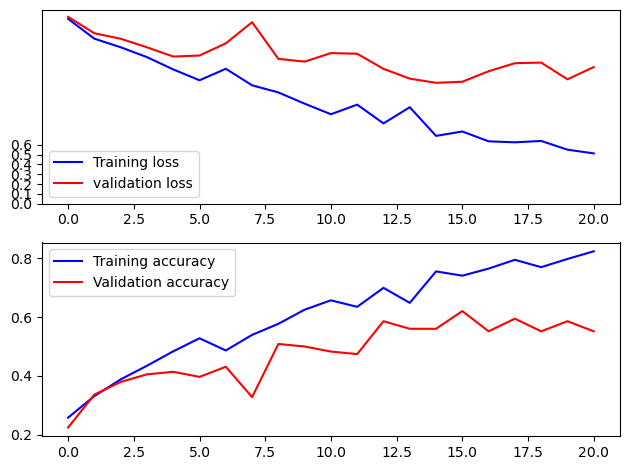

In [46]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [47]:
y_pred = model.predict(X_test)
prediction_labels = np.argmax(y_pred, axis = 1)

10/10 [==============================] - 1s 24ms/step


In [48]:
true_labels = np.argmax(y_test, axis = 1)

In [49]:
print(classification_report(true_labels, prediction_labels))

              precision    recall  f1-score   support

           0       0.76      0.83      0.79        23
           1       0.97      0.85      0.91        40
           2       0.85      0.81      0.83        42
           3       0.85      0.85      0.85        33
           4       0.91      0.76      0.83        41
           5       0.81      0.85      0.83        26
           6       0.76      0.95      0.85        44
           7       0.90      0.90      0.90        40

    accuracy                           0.85       289
   macro avg       0.85      0.85      0.85       289
weighted avg       0.86      0.85      0.85       289



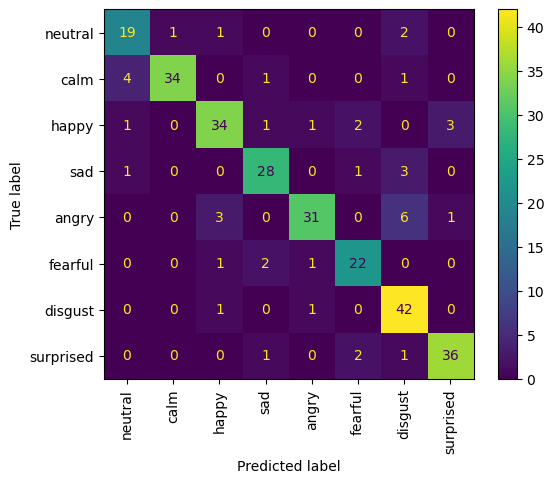

In [50]:
ConfusionMatrixDisplay.from_predictions(true_labels, prediction_labels, display_labels=list(emotions.values()), xticks_rotation = 'vertical')

## Result: CNN-LSTM Model Accuracy is 85% for Traning Dataset

36/36 [==============================] - 1s 28ms/step
              precision    recall  f1-score   support

           0       0.57      0.79      0.67        73
           1       0.93      0.76      0.83       152
           2       0.74      0.77      0.75       151
           3       0.79      0.80      0.80       159
           4       0.94      0.81      0.87       151
           5       0.83      0.78      0.81       166
           6       0.78      0.88      0.83       148
           7       0.93      0.95      0.94       152

    accuracy                           0.82      1152
   macro avg       0.81      0.82      0.81      1152
weighted avg       0.83      0.82      0.82      1152



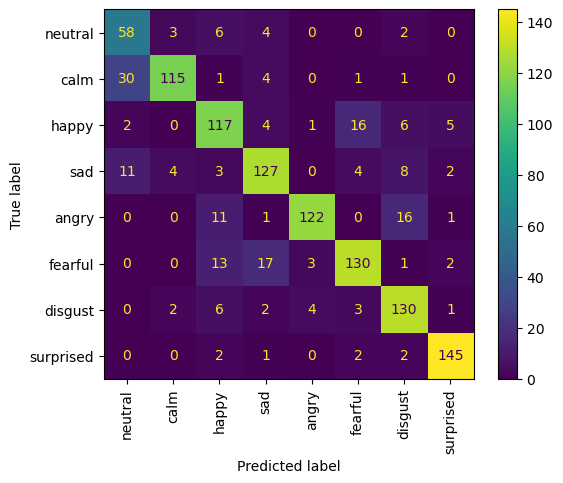

In [51]:
y_pred_train = model.predict(X_train)
prediction_labels_train = np.argmax(y_pred_train, axis = 1)

true_labels_train = np.argmax(y_train, axis = 1)

print(classification_report(true_labels_train, prediction_labels_train))
ConfusionMatrixDisplay.from_predictions(true_labels_train, prediction_labels_train, display_labels=list(emotions.values()), xticks_rotation = 'vertical')

## Result: CNN-LSTM Model Accuracy is 82% for Test Dataset

#### Observation:

    1. These results reflect the model's high capacity to generalize from the training data to unseen test data, suggesting an effective balance between model complexity and predictive performance. 

    2. The close proximity of training and test accuracies also indicates that the model is not overfitting to the training data, which is an excellent sign of its robustness.

## CNN-biLSTM

In [55]:
# Create a Sequential model
model = Sequential()

# CNN layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# LSTM layers
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Bidirectional(LSTM(50)))

model.add(Dropout(0.3))
# Dense layer for classification
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 163, 32)           18464     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 81, 32)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 79, 64)            6208      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 39, 64)           0         
 1D)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 39, 100)          46000     
 l)                                                              
                                                      

In [56]:
early = EarlyStopping(monitor="val_accuracy",mode="max",patience=5, min_delta=0.001, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=1,factor=0.3, min_lr=0.0001, mode = 'max')
model_checkpoint_callback = ModelCheckpoint(
    filepath="./cnn_bilstm_model_checkpoint.ckpt",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
callbacks_list = [early, learning_rate_reduction, model_checkpoint_callback]
callbacks = callbacks_list

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, callbacks=callbacks)

Epoch 1/30
33/33 [==============================] - 6s 90ms/step - loss: 1.9883 - accuracy: 0.1902 - val_loss: 1.9343 - val_accuracy: 0.1897 - lr: 0.0010
Epoch 2/30
33/33 [==============================] - 2s 64ms/step - loss: 1.7757 - accuracy: 0.3060 - val_loss: 1.7599 - val_accuracy: 0.2931 - lr: 0.0010
Epoch 3/30
33/33 [==============================] - 2s 65ms/step - loss: 1.6431 - accuracy: 0.3813 - val_loss: 1.6566 - val_accuracy: 0.3534 - lr: 0.0010
Epoch 4/30
33/33 [==============================] - 2s 62ms/step - loss: 1.5246 - accuracy: 0.4286 - val_loss: 1.5667 - val_accuracy: 0.3276 - lr: 0.0010
Epoch 5/30
33/33 [==============================] - 2s 64ms/step - loss: 1.3660 - accuracy: 0.4923 - val_loss: 1.3856 - val_accuracy: 0.4828 - lr: 0.0010
Epoch 6/30
33/33 [==============================] - 2s 63ms/step - loss: 1.2710 - accuracy: 0.5328 - val_loss: 1.5236 - val_accuracy: 0.3879 - lr: 0.0010
Epoch 7/30
33/33 [==============================] - 2s 70ms/step - loss: 1.1

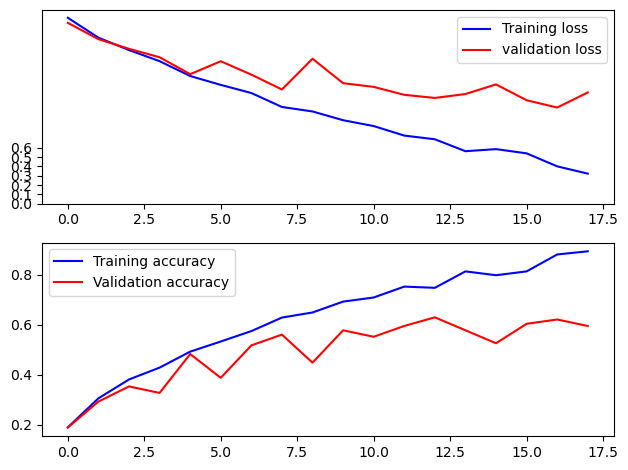

In [57]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

10/10 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

           0       0.44      0.17      0.25        23
           1       0.60      0.88      0.71        40
           2       0.58      0.36      0.44        42
           3       0.41      0.39      0.40        33
           4       0.71      0.61      0.66        41
           5       0.46      0.81      0.58        26
           6       0.67      0.73      0.70        44
           7       0.74      0.65      0.69        40

    accuracy                           0.59       289
   macro avg       0.58      0.57      0.55       289
weighted avg       0.60      0.59      0.58       289



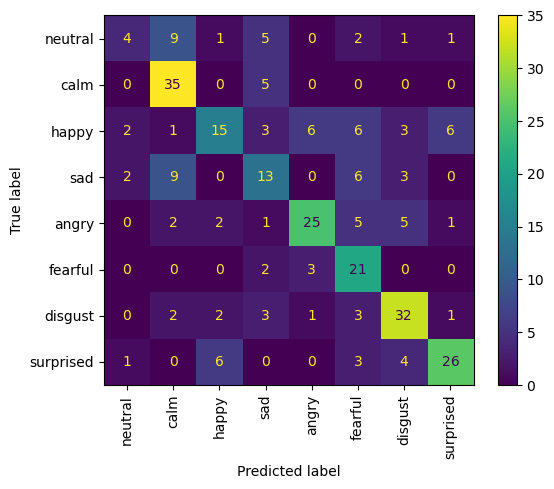

In [58]:
y_pred = model.predict(X_test)
prediction_labels = np.argmax(y_pred, axis = 1)

print(classification_report(true_labels, prediction_labels))
ConfusionMatrixDisplay.from_predictions(true_labels, prediction_labels, display_labels=list(emotions.values()), xticks_rotation = 'vertical')

## Result: CNN-biLSTM Model Accuracy is 59% for Traning Dataset

36/36 [==============================] - 1s 20ms/step
              precision    recall  f1-score   support

           0       0.67      0.45      0.54        73
           1       0.64      0.86      0.73       152
           2       0.87      0.62      0.73       151
           3       0.76      0.69      0.73       159
           4       0.86      0.85      0.86       151
           5       0.77      0.91      0.84       166
           6       0.89      0.89      0.89       148
           7       0.87      0.90      0.88       152

    accuracy                           0.79      1152
   macro avg       0.79      0.77      0.77      1152
weighted avg       0.80      0.79      0.79      1152



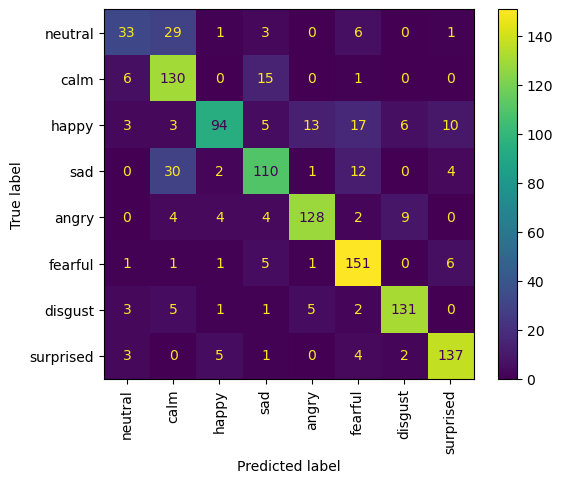

In [59]:
y_pred_train = model.predict(X_train)
prediction_labels_train = np.argmax(y_pred_train, axis = 1)

true_labels_train = np.argmax(y_train, axis = 1)

print(classification_report(true_labels_train, prediction_labels_train))
ConfusionMatrixDisplay.from_predictions(true_labels_train, prediction_labels_train, display_labels=list(emotions.values()), xticks_rotation = 'vertical')

## Result: CNN-biLSTM Model Accuracy is 79% for Test Dataset

#### Observation:
    1. These outcomes reveal a disparity where the model underperforms on the training dataset but shows better generalization on the test dataset. 
    
    2. This unusual pattern might suggest that the model could be underfit to the training data or that there might be a high variance in the data that allows for better performance on specific samples within the test set.

In [71]:
import matplotlib.pyplot as plt
from tabulate import tabulate

models = ['Ensemble SVM', 'LSTM', 'CNN-LSTM', 'CNN-biLSTM']
training_accuracies = [77, 42, 85, 59]
testing_accuracies = [69, 65, 82, 79]
table_data = []
for model, train_acc, test_acc in zip(models, training_accuracies, testing_accuracies):
    table_data.append([model, train_acc, test_acc])

headers = ['Model', 'Training Accuracy (%)', 'Testing Accuracy (%)']

print(tabulate(table_data, headers=headers, tablefmt='grid'))

+--------------+-------------------------+------------------------+
| Model        |   Training Accuracy (%) |   Testing Accuracy (%) |
+==============+=========================+========================+
| Ensemble SVM |                      77 |                     69 |
+--------------+-------------------------+------------------------+
| LSTM         |                      42 |                     65 |
+--------------+-------------------------+------------------------+
| CNN-LSTM     |                      85 |                     82 |
+--------------+-------------------------+------------------------+
| CNN-biLSTM   |                      59 |                     79 |
+--------------+-------------------------+------------------------+
